In [ ]:
from torchnlp.datasets import penn_treebank_dataset
import torch
from torchnlp.samplers import BPTTBatchSampler
from torch.utils.data import DataLoader
from rsm_samplers import MNISTSequenceSampler, ptb_pred_sequence_collate
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
import numpy as np
import torchvision.utils as vutils
from functools import reduce, partial
import matplotlib.pyplot as plt

In [86]:
def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)


In [222]:
import rsm_samplers
reload(rsm_samplers)

from torch.utils.data import DataLoader, BatchSampler

dataset = datasets.MNIST("~/nta/datasets", download=True,
                                               transform=transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                                               ]),)

sl = 12
bs = 64
m=64
n=5
SEQ = [[0,1,2,3],[4,5,6,7],[9,8,7,6]]
d_in = d_out = 28 ** 2
sampler = rsm_samplers.MNISTSequenceSampler(dataset, batch_size=bs, sequences=SEQ, randomize_sequences=True)
batch_sampler = BatchSampler(sampler, batch_size=sl * bs + 1, drop_last=True)

collate_fn = partial(rsm_samplers.pred_sequence_collate, 
                     bsz=bs,
                     seq_length=sl,
                    return_inputs=True)
loader = DataLoader(dataset,
                    batch_sampler=batch_sampler,
                    collate_fn=collate_fn)
model = rsm.RSMLayer(d_in=d_in, d_out=d_out, m=m, n=n)

criterion = MSELoss()

LR = .0005
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [249]:
def activity_square(vector):
    n = len(vector)
    side = int(np.sqrt(n))
    if side ** 2 < n:
        side += 1
    square = torch.zeros(side ** 2)
    square[:n] = vector
    return square.view(side, side)
    
def plot_col_distrs(distrs, n_labels=10):
    col_act_avgs = []
    fig, axs = plt.subplots(n_labels, n_labels, dpi=200, 
                            sharex=True, sharey=True,
                            gridspec_kw={'wspace': 0, 'hspace': 0})
    for i in range(n_labels):
        for j in range(n_labels):
            ax = axs[i][j]
            ax.axis('off')
            key = '%d-%d' % (i, j)
            if key in distrs:
                activity_arr = distrs[key]
                ax.set_title("%d -> %d" % (i, j), fontsize=7)
                dist = torch.stack(activity_arr)
                mean_act = dist.mean(dim=0)
                ax.imshow(activity_square(mean_act))
            else:
                ax.set_axis_off()
    plt.show()
    return {}

0 loss 0.7249010867542691
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


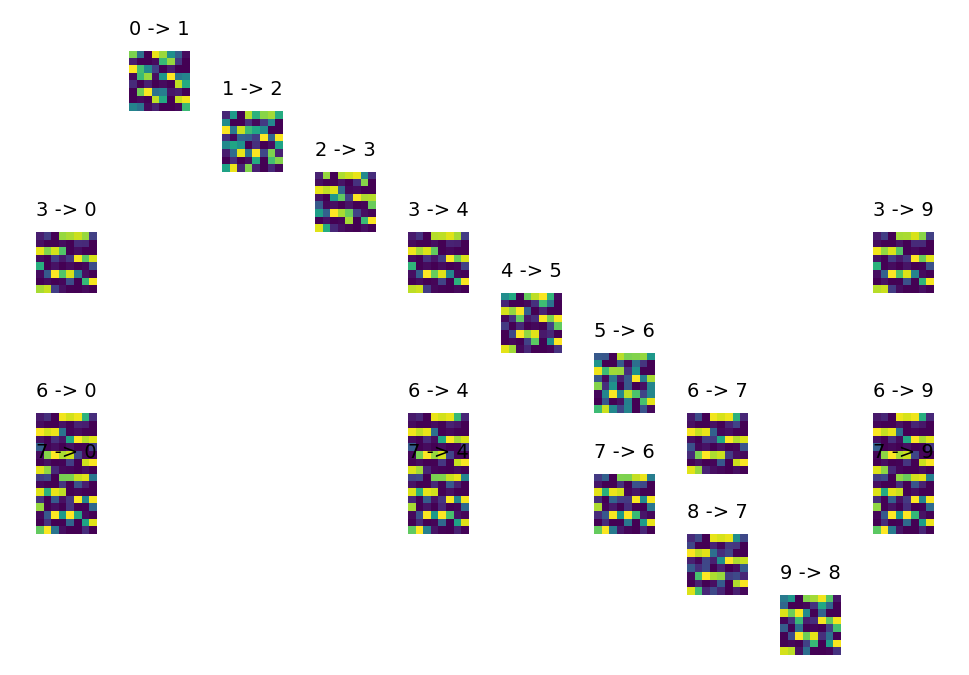

1 loss 0.7238524688614739
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


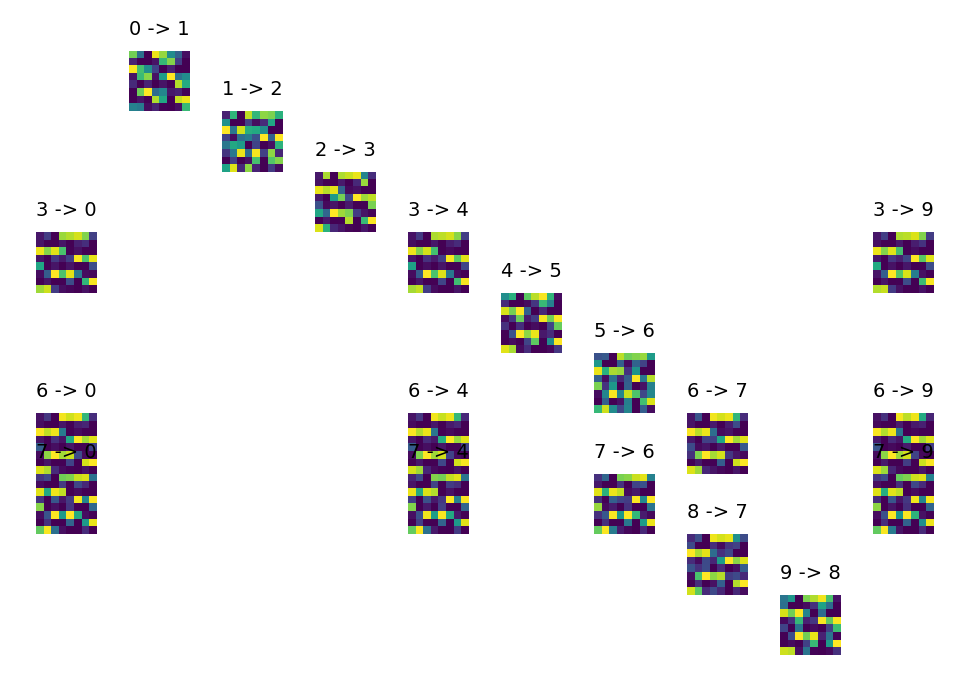

2 loss 0.7227470676104227
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


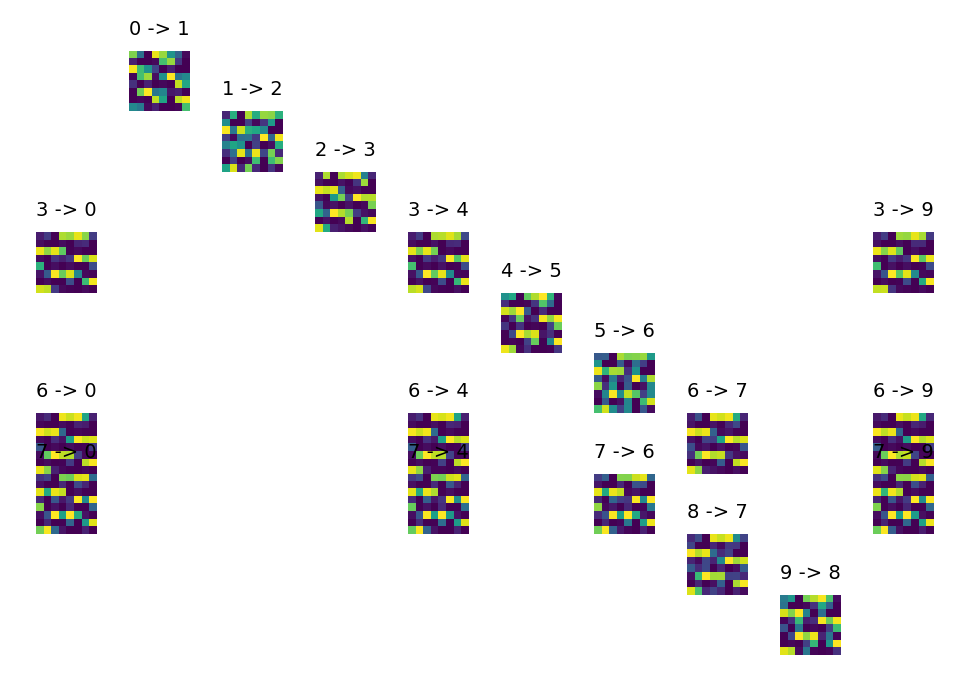

3 loss 0.7210938334465027
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


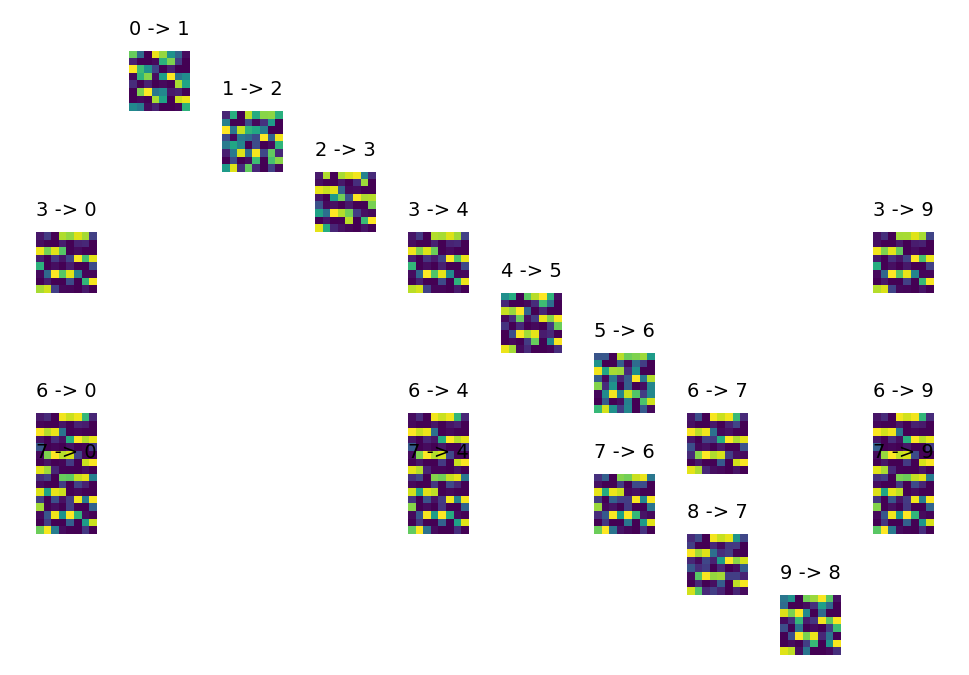

4 loss 0.7250747548209296
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


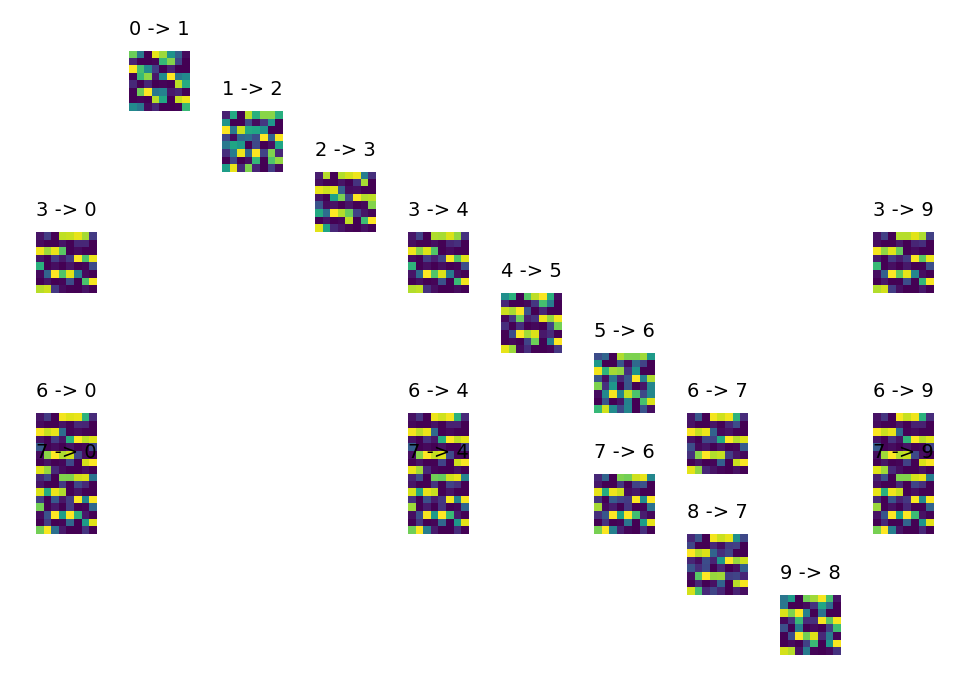

In [250]:
hidden = model.init_hidden(bs)

MAX_BATCHES = 10
CLASSES = 10
PLOT_EACH = 10
EPOCHS = 5

condtl_column_dists = {}  # 'digit-digit' -> list of distribution arrays

for epoch in range(EPOCHS):
    total_loss = 0.0
    for i, (data, targets, pred_targets, input_labels) in enumerate(loader):
        optimizer.zero_grad()
        output, hidden, x_bs = model(data, hidden)
        x_b, phi, psi = hidden
        for x_b_batch, label_batch, target_batch in zip(x_bs, input_labels, pred_targets):
            for _x_b, label, target in zip(x_b_batch, label_batch, target_batch):
                digit = label.item()
                next_digit = target.item()
                col_activity = _x_b.detach().view(m, -1).max(dim=1).values
                key = "%d-%d" % (digit, next_digit)
                if key not in condtl_column_dists:
                    condtl_column_dists[key] = []
                condtl_column_dists[key].append(col_activity)

        loss = criterion(output, targets)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        
        hidden = _repackage_hidden(hidden)

        if i >= MAX_BATCHES - 1:
            break

    print(epoch, 'loss', total_loss / i)
    condtl_column_dists = plot_col_distrs(condtl_column_dists)

In [ ]:
a = torch.randn(2, 12).reshape(2, 4, 3)
print(a)
values, indices = torch.topk(a, 2)
print(indices)
arr = a.new_zeros(a.size())  # Zeros, conserve device
arr.scatter_(2, indices, 1)

In [ ]:
len(corpus.dictionary)

In [ ]:
[len(corpus.train), len(corpus.valid), len(corpus.test)]

In [ ]:
batch_size = 300
batches = len(corpus.train) / batch_size
0.25 * batches

In [ ]:
from torch.nn.functional import softmax

def topk_mask(a, k, dim=0, do_softmax=False):
    """
    Return a 1 for the top b elements in the last dim of a, 0 otherwise
    """
    if do_softmax:
        return softmax(a)
    else:
        values, indices = torch.topk(a, k)
    arr = a.new_zeros(a.size())  # Zeros, conserve device
    arr.scatter_(dim, indices, 1)
    return arr

a = torch.randn((3, 4))
print(a)
topk_mask(a, 1, dim=1, do_softmax=True)

In [ ]:
from torch import nn
from copy import deepcopy
import matplotlib.pyplot as plt

class LocalLinear(nn.Module):
    """
    """
    def __init__(self, in_features, local_features, kernel_size, stride=1, bias=True):
        super(LocalLinear, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

        fold_num = (in_features - self.kernel_size) // self.stride + 1
        self.lc = nn.ModuleList([deepcopy(nn.Linear(kernel_size, local_features, bias=bias))
                                 for _ in range(fold_num)])

    def forward(self, x):
        x = x.unfold(-1, size=self.kernel_size, step=self.stride)
        fold_num = x.shape[1]
        x = torch.cat([self.lc[i](x[:, i, :]) for i in range(fold_num)], 1)
        return x


class ActiveDendriteLayer(torch.nn.Module):
    """
    Local layer for active dendrites. Similar to a non-shared weight version of a 
    2D Conv layer.
    
    Note that dendrites are fully connected to input, local layer used only for connecting
    neurons and their dendrites
    """
    def __init__(self, input_dim, n_cells=50, n_dendrites=3):
        super(ActiveDendriteLayer, self).__init__()
        self.n_cells = n_cells
        self.n_dendrites = n_dendrites
        
        total_dendrites = n_dendrites * n_cells
        self.linear_dend = nn.Linear(input_dim, total_dendrites)
        self.linear_neuron = LocalLinear(total_dendrites, 1, n_dendrites, stride=n_dendrites)
        
    def __repr__(self):
        return "ActiveDendriteLayer neur=%d, dend per neuron=%d" % (self.n_cells, self.n_dendrites)
    
    def forward(self, x):
        x = F.relu(self.linear_dend(x))
        x = self.linear_neuron(x)
        return x
 
x = torch.randn(1, 5)
print(x)
adl = ActiveDendriteLayer(5, 4, 2)
print(adl(x))


In [ ]:
x = torch.randn(5, 3)
x[:, -2:] = 1
print(x)

In [33]:
class BitwiseWordEmbedding(object):

    def __init__(self, vocab_size=10000, dim=28):
        self.vocab_size = vocab_size
        self.embedding_dict = {}
        self.dim = dim

    def generate_embeddings(self):
        for i in range(self.vocab_size):
            self.embedding_dict[i] = self.embed(i)

    def embed(self, i):
        first = "{0:b}".format(i).zfill(self.dim // 2)
        return first + self.inverse(first)

    def inverse(self, binstr):
        return ''.join('1' if x == '0' else '0' for x in binstr)

bwe = BitwiseWordEmbedding()

bwe.embed(9381)

'1001001010010101101101011010'

In [8]:
from importlib import reload 
import viz_util
reload(viz_util)

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO
import io
import numpy as np
import matplotlib.pyplot as plt


ax, fig = viz_util.plot_confusion_matrix(np.array([1,2,3]), np.array([1,2,0]), ['0', '1', '2', '3'])

img = viz_util.fig2img(fig)

print(img.shape)
plt.imsave('test.png', img, format='png')


(288, 432, 3)


In [55]:
torch.range(0, 5).expand((3, 6)).t()

/Users/jgordon/miniconda3/envs/standard/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """Entry point for launching an IPython kernel.


tensor([[0., 0., 0.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]])

In [63]:
bsz = 10
sl = 5
vs = 10
a = (torch.rand(bsz) * vs).long()
print(a)
a = a.expand((sl, bsz))
inc = torch.arange(0, sl, dtype=torch.long).expand((bsz, sl)).t()
a + inc

tensor([5, 5, 2, 0, 2, 0, 3, 5, 4, 9])


tensor([[ 5,  5,  2,  0,  2,  0,  3,  5,  4,  9],
        [ 6,  6,  3,  1,  3,  1,  4,  6,  5, 10],
        [ 7,  7,  4,  2,  4,  2,  5,  7,  6, 11],
        [ 8,  8,  5,  3,  5,  3,  6,  8,  7, 12],
        [ 9,  9,  6,  4,  6,  4,  7,  9,  8, 13]])